In [52]:
import numpy as np
from torch.autograd import Variable
import pandas as pd

In [53]:
data=pd.read_csv('mitbih_train.csv')

In [54]:
DF=pd.DataFrame(data)

In [55]:
import matplotlib.pyplot as plt

In [56]:
new_column_name = ['label']
for num in range(DF.shape[1]-1):
    tem = 'dim' + str(num)
    new_column_name.append(tem)
DF.columns = new_column_name    

In [57]:
train_MI=DF.iloc[0:7000]
test_MI=DF.iloc[7000:9000]
train=np.asarray(train_MI)
train=train.reshape(7000, 188, 1)
test=np.asarray(test_MI)
test=test.reshape(2000, 188, 1)

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(188, 90)
        self.fc21 = nn.Linear(90, 20)
        self.fc22 = nn.Linear(90, 20)
        self.fc3 = nn.Linear(20, 90)
        self.fc4 = nn.Linear(90, 188)

    def encode(self, x):
        x=x.squeeze()
        h1 = F.relu(self.fc1(x))
        mu=F.relu(self.fc21(h1))
        logvar=F.relu(self.fc22(h1))
        return mu,logvar

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.DoubleTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE()
model.double()

if torch.cuda.is_available():
    model.cuda()

reconstruction_function = nn.MSELoss(size_average=False)


def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    BCE = reconstruction_function(recon_x, x)  # mse loss
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return BCE + KLD


optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


C:\Users\KrishnaS\Anaconda3\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [67]:
for epoch in range(4):
    model.train()
    train_loss = 0
    for i in range(len(train)):
        b=torch.from_numpy(train[i])
        optimizer.zero_grad()
        output, mu, logvar = model(b)
        loss = loss_function(output, b.squeeze(), mu, logvar)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train)))

C:\Users\KrishnaS\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # Remove the CWD from sys.path while we load stuff.


====> Epoch: 0 Average loss: 6.0914
====> Epoch: 1 Average loss: 5.6351
====> Epoch: 2 Average loss: 5.5333
====> Epoch: 3 Average loss: 5.8319


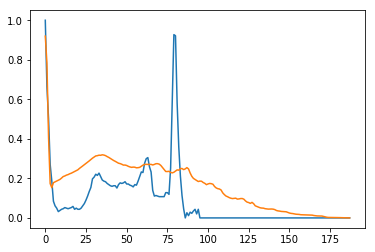

In [70]:
plt.plot(test[1000])
k=torch.from_numpy(test[1000])
e,f,g=model(k)
plt.plot(e.detach().numpy())